## Ejercicio de Feedback: Clustering

# Introducción y planteamiento del problema

"**Ayuda Internacional**" es una ONG humanitaria internacional comprometida con la lucha contra la pobreza y con proporcionar a las personas de países subdesarrollados servicios básicos y ayuda en tiempos de desastres y calamidades naturales. Esta ONG ha logrado recaudar aproximadamente 10 millones de dólares. Este dinero debe ahora asignarse de manera estratégica y eficaz. Por lo tanto, para decidir la selección de los países que más necesitan ayuda, se deben tomar decisiones basadas en datos.

En consecuencia, resulta necesario **categorizar los países utilizando factores socioeconómicos y de salud** que determinen el desarrollo general de cada país. Basándose en estos grupos de países, definidos por sus condiciones, se distribuirán los fondos para brindar asistencia durante desastres y calamidades naturales. Este es un caso claro de clustering, donde se requiere crear grupos de países basados en las diferentes características presentes.

**Objetivo**:


*   Agrupar países en función de características numéricas socioeconómicas.
*   Determinar qué grupos de países requieren ayuda y en qué grado



## Nuestro conjunto de datos




* **country**: Nombre del país.
* **child_mort**: Muertes de niños menores de 5 años por cada 1000 nacidos vivos.
* **exports**: Exportaciones de bienes y servicios per cápita, expresadas como porcentaje del PIB per cápita.
* **health**: Gasto total en salud per cápita, expresado como porcentaje del PIB per cápita.
* **imports**: Importaciones de bienes y servicios per cápita, expresadas como porcentaje del PIB per cápita.
* **Income**: Ingreso neto por persona.
* **Inflation**: Tasa de crecimiento anual del PIB total.
* **life_expec**: Número promedio de años que un recién nacido viviría si se mantienen los patrones actuales de mortalidad.
* **total_fer**: Número de hijos que nacerían por mujer si las tasas actuales de fertilidad por edad permanecen constantes.
* **gdpp**: PIB per cápita, calculado como el PIB total dividido entre la población total.




## 1 Importación de librerías

In [ ]:
#Es posible que necesitéis estas librerías (y muchas más)
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
!pip install -U kaleido
import kaleido

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
import plotly as py
import plotly.graph_objs as go

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning: 


This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.

  from .kaleido import Kaleido


## 2 Análisis Exploratorio de los datos

**Ejercicio 1** - Llevar a cabo un procedimiento de EDA para obtener información acerca de los datos:

*  Declara el tamaño del dataset y muestra algunos registros por pantalla. Muestra los estadísticos (media, desviación típica, min, max...) relevantes de cada una de las variables. Observando el tipo de características, ¿podemos usarlas todas en un algoritmo de agrupación?

*  Analiza la distribución de cada una de las variables mediante gráficas de densidad y boxplots (se valora utilizar el mínimo código posible para mostrar todas las gráficas). ¿Están bien distribuidas las variables? ¿Qué podemos comentar de este análisis?



**Respuesta**

*   La variable country no puede ser usada porque es meramente una variable identificativa (además de que es de tipo caracter).
*   De los histogramas deducimos que las distribucione de las variables son muy sesgadas, con muy pocas distribuciones simétricas. Este hecho implica que o bien los clústeres están muy comprimidos, o bien que van a haber muy pocos clústeres. Por otro lado, los boxplots nos dicen que nuestros datos no tienen excesivos outliers en comparación, salvo las variables gdpp e income (principalmente la primera)



In [ ]:
df_ong = pd.read_csv("Country-data.csv")
print(f"El data set consta de {df_ong.shape[0]} filas y {df_ong.shape[1]} columnas")

display(df_ong.head()) # Vemos unos pocos datos del data set

display(df_ong.describe()) # Obtenemos algunos estadísiticos de cada variable del data set

El data set consta de 167 filas y 10 columnas


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


array([[<Axes: title={'center': 'child_mort'}>,
        <Axes: title={'center': 'exports'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'imports'}>,
        <Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'inflation'}>],
       [<Axes: title={'center': 'life_expec'}>,
        <Axes: title={'center': 'total_fer'}>,
        <Axes: title={'center': 'gdpp'}>]], dtype=object)

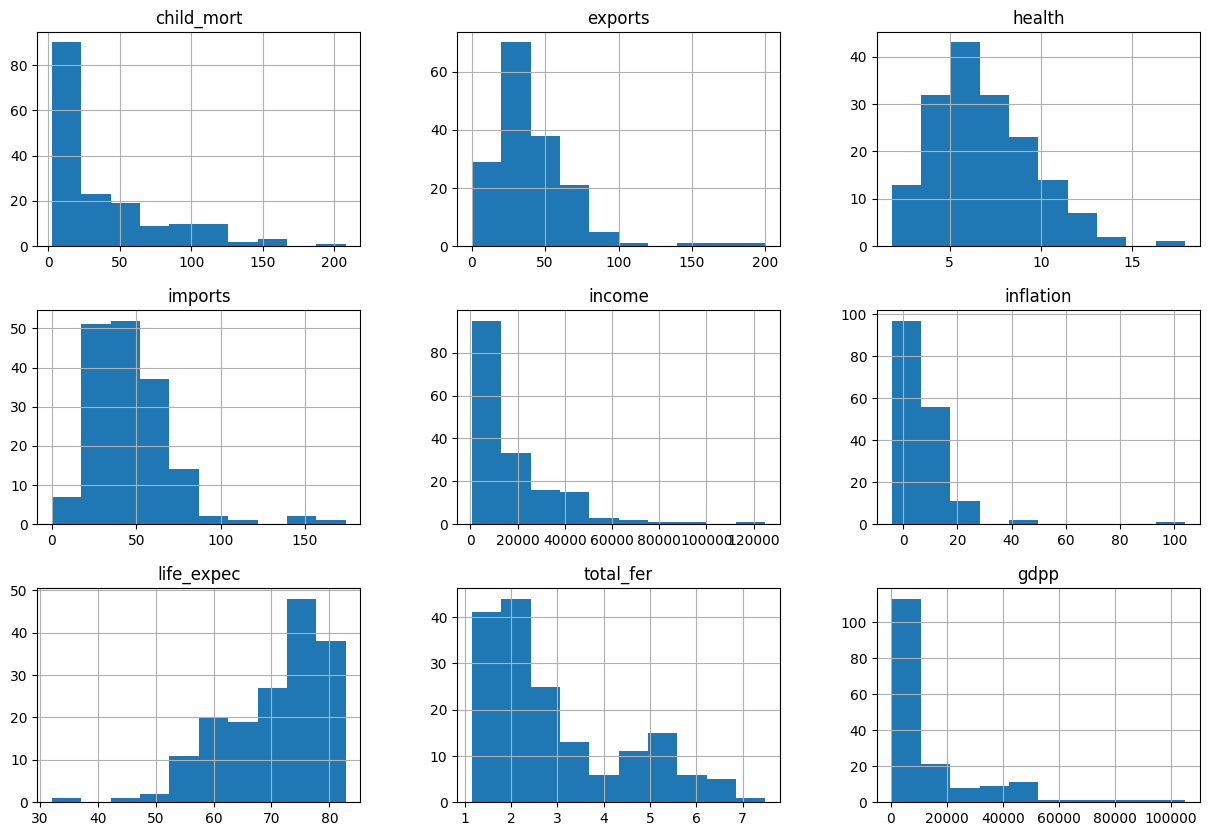

In [ ]:
display(df_ong.hist(figsize=(15, 10))) # Hacemos un histograma rapido de cada variable del data set

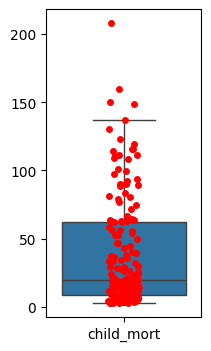

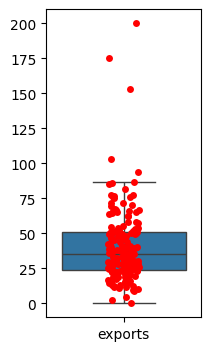

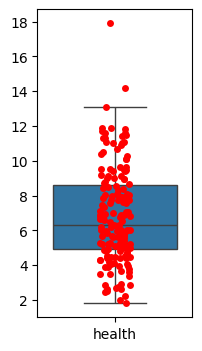

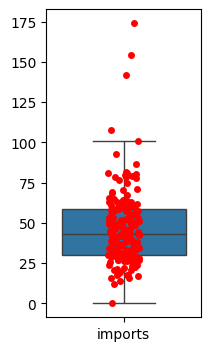

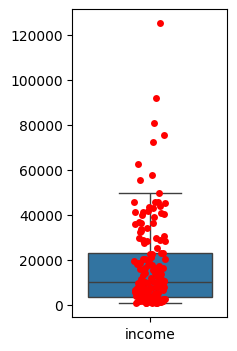

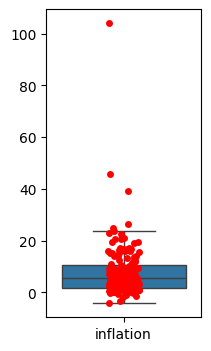

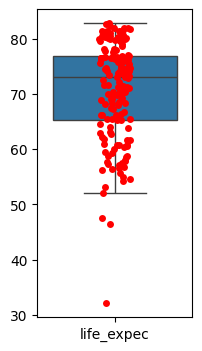

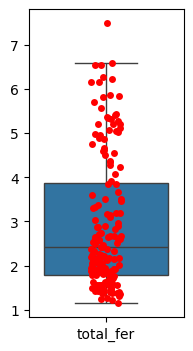

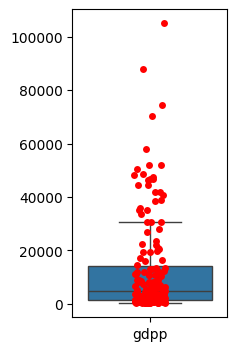

In [ ]:
# Hacemos boxplots de cada variable del data set para hacernos a la idea de cuantos outliers posee

for i in df_ong.columns[1:len(df_ong.columns)]:
  plt.figure(figsize = (2,4))
  sns.boxplot(df_ong[[i]], showfliers=False)
  sns.stripplot(df_ong[[i]], color="red")
  plt.show()

## 3 Extracción de las características

**Ejercicio 2** - Realizaremos transformaciones en nuestros datos en crudo para obtener las variables con las que realizar el clustering.

*   Muestra la matriz de correlaciones por pantalla y comenta resumidamente sus conclusiones.

*   Vamos a **agrupar todas nuestras nueve variables en tres grandes indicadores** diferentes: **Salud** (4 variables), **Comercio** (2 variables) y **Finanzas** (3 variables). Definir las agrupaciones en base a lo que significa cada variable. Para construir cada uno de los indicadores, sumaremos cada una de las variables agrupadas en ese indicador dividida por su media (Por ejemplo: Comercio = (variable1/media_variable1) + (variable2/media_variable2)

* Una vez construidos los indicadores, tenemos que asegurarnos que los tres estén a la **misma escala**. Para ello tenemos que decidirnos por la **estandarización** o la **normalización**, ambas funciones nativas de SKLearn. Visualiza la distribución de los 3 grandes indicadores, decide que método emplear (estandarización/normalización) y aplícalo a nuestros datos.






**Respuesta**

*   He creado dos matrices de correlación: una con el método de Spearman para ver la monotonía de las variables y otra con el método de Pearson para verificar si la relación es lineal o para que en el caso de que la correlación de Pearson es de 0 ver si sigue otra relación. De ambas matrices observamos que hay algunas variables que están altamente correlacionadas (como income y gdpp o child_mort y life_expec). Otras variables (como income y life_expec) no tienen ningún tipo de relación
*   

* De los histogramas observamos que los tres indicadores poseen una distribución muy sesgada, lo que puede dar lugar a muchos outliers. Los boxplots nos confirman estas creencias, sobre todo con los indicadores de Salud y Finanzas. A pesar de ser outliers, estos son aproximadamente del mismo orden de magnitud que los valores frecuentes. Por otro lado, la visualicación tridimensional de los indicadores nos dice que la transición entre clústeres (si los hay) es continua y no abrupta, ya que es difícil discernirlos con claridad. El método de escalado que decido elegir es la normalización porque, a pesar de que esta normalización es sensible a los outliers, es sensible si los outliers son mucho más grandes que los valores normales, $\frac{x_{outlier}}{x_{normal}} \gg 1$, y en nuestro caso esto no se da, por lo tanto no se distorsionan tanto los clústeres originales. Otro motivo por el que es mejor en este caso la normalización sobre la estandarización es porque esta última no te reduce el conjunto de datos a una escala fija y por lo tanto las distancias o densidades pueden ser muy diferentes, lo que podría afectar al rendimiento del modelo.


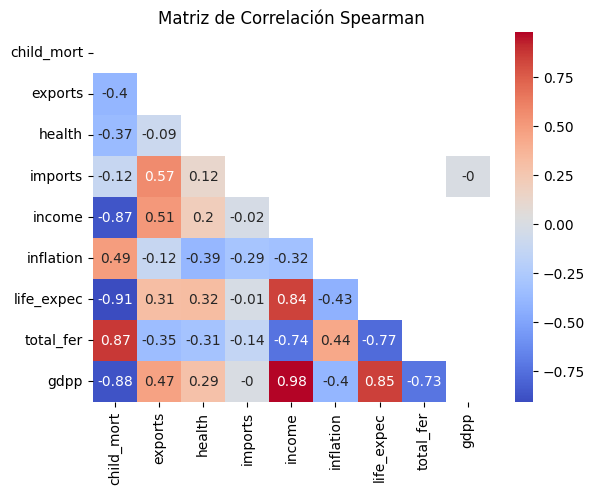

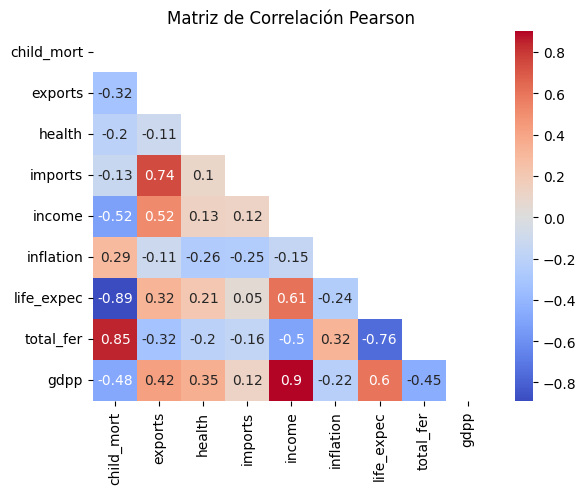

In [ ]:
# Calcular la matriz de correlación Spearman
df = df_ong[df_ong.columns[1:len(df_ong.columns)]].dropna()

corr_matrix = df.corr(method="spearman").round(2)

# Máscaras para ocultar una parte de la matriz
ut = np.triu(corr_matrix)  # Triángulo superior

sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, cbar=True, mask=ut)
plt.title("Matriz de Correlación Spearman")
plt.show()

# Calcular la matriz de correlación Pearson

corr_matrix = df.corr(method="pearson").round(2)

# Máscaras para ocultar una parte de la matriz

ut = np.triu(corr_matrix)  # Triángulo superior

sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, cbar=True, mask=ut)
plt.title("Matriz de Correlación Pearson")
plt.show()

In [ ]:
col_salud = ["child_mort", "health", "life_expec", "total_fer"]
col_comercio = ["exports", "imports"]
col_finanzas = ["income", "inflation", "gdpp"]

Salud = df_ong[col_salud]
Comercio = df_ong[col_comercio]
Finanzas = df_ong[col_finanzas]

Salud = df_ong["child_mort"] / np.mean(df_ong["child_mort"]) + \
        df_ong["health"] / np.mean(df_ong["health"])         + \
        df_ong["life_expec"] / np.mean(df_ong["life_expec"]) + \
        df_ong["total_fer"] / np.mean(df_ong["total_fer"])

Comercio = df_ong["exports"] / np.mean(df_ong["exports"]) + \
           df_ong["imports"] / np.mean(df_ong["imports"])

Finanzas = df_ong["income"] / np.mean(df_ong["income"])       + \
           df_ong["inflation"] / np.mean(df_ong["inflation"]) + \
           df_ong["gdpp"] / np.mean(df_ong["gdpp"])

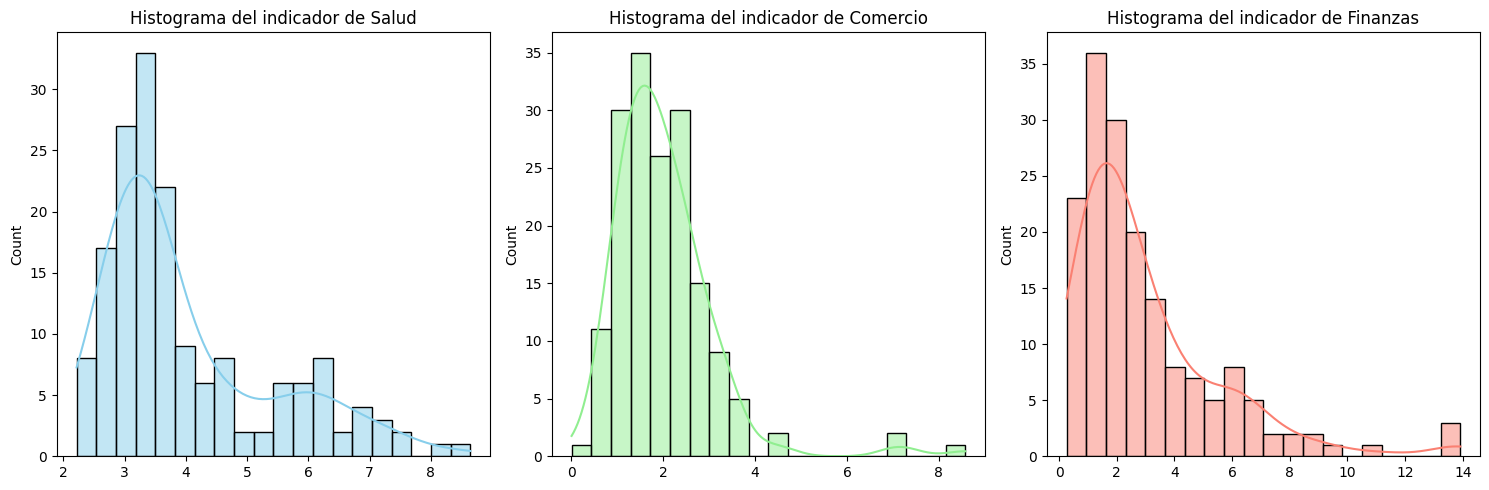

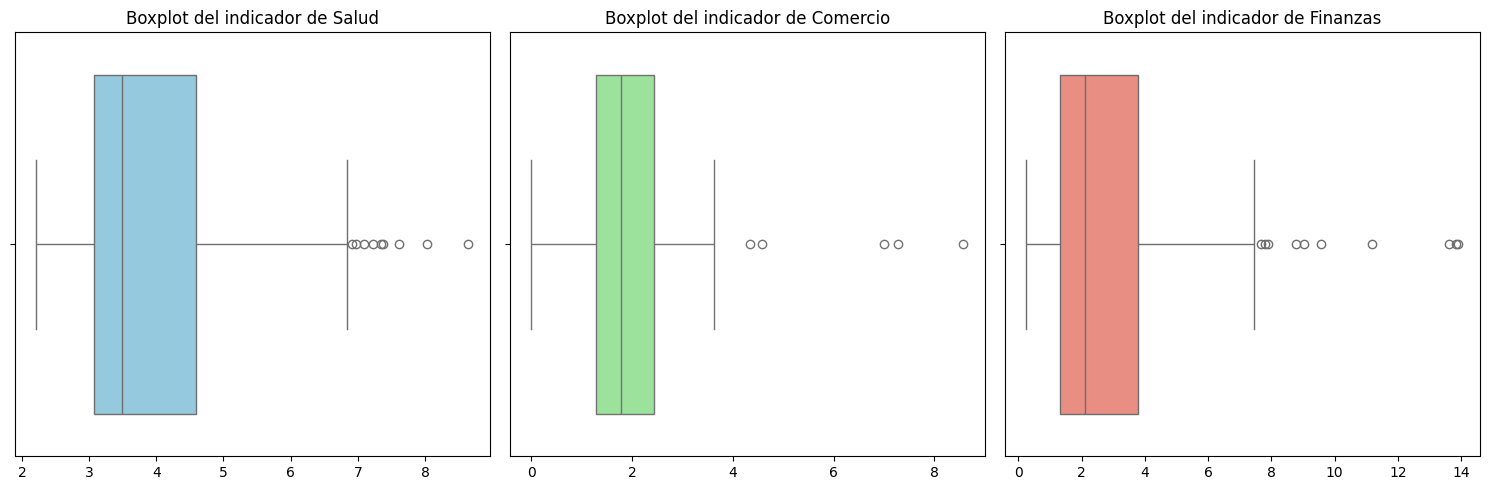

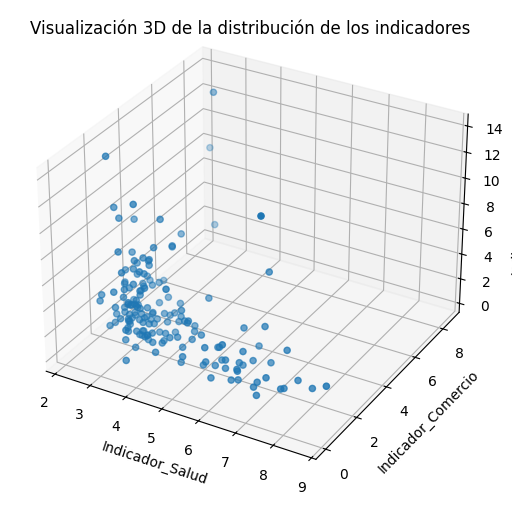

In [ ]:
# Procedemos a la visualizacion de los tres indicadores

# --- Histogramas ---
_, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(Salud, ax=ax[0], color="skyblue", bins=20, kde=True)
ax[0].set_title("Histograma del indicador de Salud")

sns.histplot(Comercio, ax=ax[1], color="lightgreen", bins=20, kde=True)
ax[1].set_title("Histograma del indicador de Comercio")

sns.histplot(Finanzas, ax=ax[2], color="salmon", bins=20, kde=True)
ax[2].set_title("Histograma del indicador de Finanzas")

plt.tight_layout()
plt.show()

# --- Boxplots ---
_, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x=Salud, ax=ax[0], color="skyblue")
ax[0].set_title("Boxplot del indicador de Salud")
ax[0].set_xlabel("")

sns.boxplot(x=Comercio, ax=ax[1], color="lightgreen")
ax[1].set_title("Boxplot del indicador de Comercio")
ax[1].set_xlabel("")

sns.boxplot(x=Finanzas, ax=ax[2], color="salmon")
ax[2].set_title("Boxplot del indicador de Finanzas")
ax[2].set_xlabel("")

plt.tight_layout()
plt.show()


fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)
sc = ax.scatter(Salud, Comercio, Finanzas)
ax.set_xlabel("Indicador_Salud")
ax.set_ylabel("Indicador_Comercio")
ax.set_zlabel("Indicador_Finanzas")
fig.suptitle("Visualización 3D de la distribución de los indicadores")
plt.show()


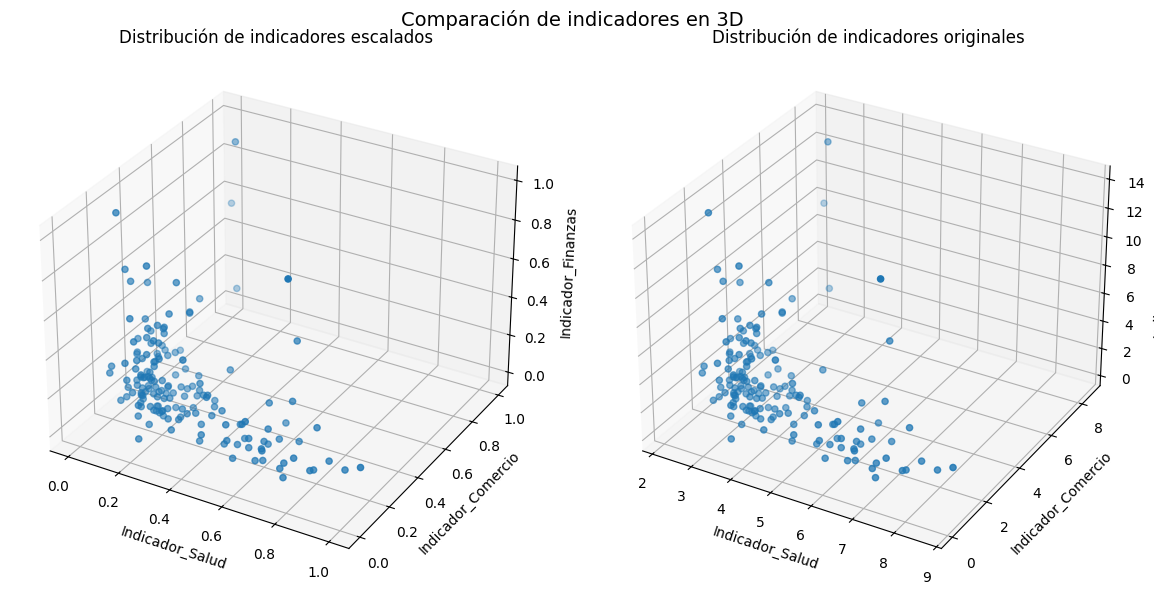

In [ ]:
# Procedemos al escalado de los datos

# Llamo al estandarizador
escalado = MinMaxScaler()

# Estandarizo mis datos
Salud_esc = pd.DataFrame(escalado.fit_transform(Salud.to_frame()), columns=["Indicador_Salud"])
Comercio_esc = pd.DataFrame(escalado.fit_transform(Comercio.to_frame()), columns=["Indicador_Comercio"])
Finanzas_esc = pd.DataFrame(escalado.fit_transform(Finanzas.to_frame()), columns=["Indicador_Finanzas"])

# Los llevo a un unico data frame

df_ind_esc = pd.concat(
    [Salud_esc,
     Comercio_esc,
     Finanzas_esc],
    axis = 1
)

# Procedemos a la visualización de los indicadore escalados

fig = plt.figure(figsize=(12, 6))

# Primer subplot (indicadores escalados)
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.scatter(df_ind_esc["Indicador_Salud"],
            df_ind_esc["Indicador_Comercio"],
            df_ind_esc["Indicador_Finanzas"])
ax1.set_xlabel("Indicador_Salud")
ax1.set_ylabel("Indicador_Comercio")
ax1.set_zlabel("Indicador_Finanzas")
ax1.set_title("Distribución de indicadores escalados")

# Segundo subplot (indicadores originales)
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.scatter(Salud,
            Comercio,
            Finanzas)
ax2.set_xlabel("Indicador_Salud")
ax2.set_ylabel("Indicador_Comercio")
ax2.set_zlabel("Indicador_Finanzas")
ax2.set_title("Distribución de indicadores originales")

# Título general
fig.suptitle("Comparación de indicadores en 3D", fontsize=14)

plt.tight_layout()
plt.show()

## 4 Entrenamiento y evaluación del modelo

**Ejercicio 3**: Una vez tenemos los datos estandarizados, procedemos a aplicar nuestro método de agrupación.

*  **Selección del algoritmo de clustering**: Argumentar de manera razonada, teniendo en cuenta nuestro problema concreto, que método de agrupación es mejor aplicar en este caso. Existe uno claramente diferenciado.

* **Ajuste de hiperparámetro/s**: Una vez seleccionado el modelo, ajusta los hiperparámetro/s para decidir el o los mejores valores del mismo. Recuerda utilizar todas las técnicas vistas en clase y hacer un análisis completo de la situación para poder tomar la decisión con toda la información disponible. La elección de los valor/es de los hiperparámetros deben estar justificados con gran profundidad y evidencias.

* **Evaluación de la agrupación**: Utiliza métricas vistas en clase y la representación visual de la agrupación final realizada para valorar la calidad de la misma. Usa las librerías 2D y 3D vistas en las prácticas.





**Respuesta**


*   El método que decido usar es el K-Means porque, en primer lugar, K-Means fuerza que todos los países estén dentro de algún cluster. Con DBSCAN habría algunos países que serían catalogados como ruido y, en este caso, existiría el problema de qué hacer con estos países. En segundo lugar, como se puede ver en la visualización tridimensional, no existe una transición discontinuo o diferenciada de los posibles clústeres. Y esto es un problema porque dbscan aglomeraría todo el conjunto de datos en un único clúster.
*   El método del Elbow nos dice que un buen número de clústeres podría   ser 3, 4 ó 5.
El método de la silueta nos dice que un buen número de clústeres podría ser 3 ó 4, aunque el 4 a veces nos da un buen valor de la métrica y a veces no.
El método del GAP Statistic nos dice que el mejor número de clústeres es 3.
El número de clústeres que decido elegir es k = 3 porque, si bien los método del Elbow y el de la silueta dependen de la inicialización de los centroides, el método del GAP no ya que se está realizando estadística. Por lo tanto, este último método refuerza la elección de k = 3.
*      



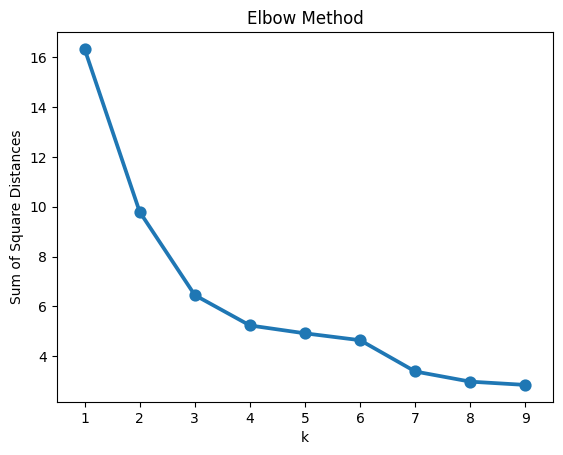

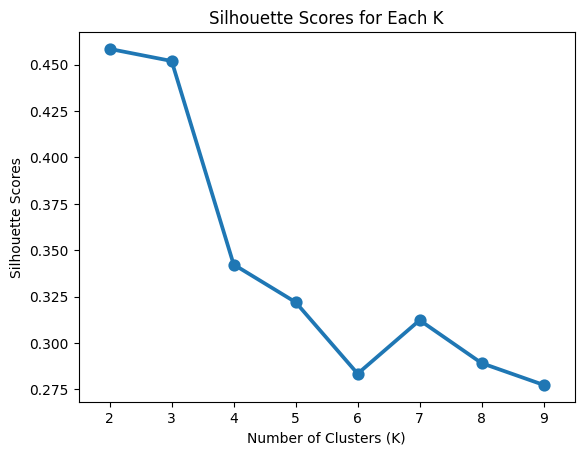

In [ ]:
# ---- Algoritmo K-Means ----

# Para el algoritmo de K-Means solo necesitamos el número de clústeres. Este se puede escoger mediantes diversas técnicas, que las expondremos a continuación

#---- Método del Elbow
sum_of_sqr_dist = {}

for k in range(1,10):
  km = KMeans(n_clusters=k, init="k-means++", max_iter=1000)
  km.fit(df_ind_esc)
  sum_of_sqr_dist[k] = km.inertia_

sns.pointplot(x=sum_of_sqr_dist.keys(), y=sum_of_sqr_dist.values())
plt.xlabel("k")
plt.ylabel("Sum of Square Distances")
plt.title("Elbow Method")
plt.show()

# ---- Método de la Silueta
silhouette = {}

for k in range(2,10):
  km = KMeans(n_clusters=k, init="k-means++", max_iter=1000)
  km.fit(df_ind_esc)
  silhouette[k] = silhouette_score(df_ind_esc, km.labels_)

sns.pointplot(x=silhouette.keys(), y=silhouette.values())
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Scores")
plt.title("Silhouette Scores for Each K")
plt.show()

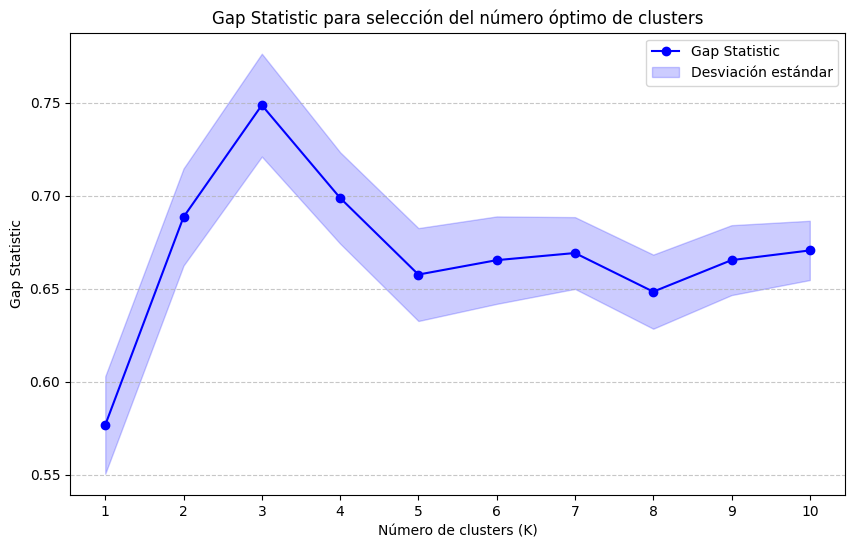

In [ ]:
# ---- Gap Statistic
# Primero definimos la funcion del gap statistic
def calculate_gap_statistic(data, refs=None, n_refs=10, max_k=10):
    """
    Calcula el Gap Statistic para el rango de clusters K = [1, max_k].

    Parámetros:
    - data: array numpy de los datos (normalizados)
    - refs: datos de referencia generados aleatoriamente (si es None, se generan internamente)
    - n_refs: número de conjuntos de referencia
    - max_k: máximo número de clusters a evaluar

    Devuelve:
    - gaps: lista con los valores Gap Statistic para cada valor de K
    - deviations: desviaciones estándar de las simulaciones
    """
    if refs is None:
        refs = np.random.uniform(low=np.min(data, axis=0), high=np.max(data, axis=0), size=(data.shape[0] * n_refs, data.shape[1]))

    gaps = []
    deviations = []

    for k in range(1, max_k + 1):
        # Ajuste del modelo KMeans en los datos reales
        kmeans = KMeans(n_clusters=k, init = 'k-means++', n_init =20)
        kmeans.fit(data)
        disp_real = np.mean(np.min(pairwise_distances(data, kmeans.cluster_centers_), axis=1))

        # Ajuste del modelo KMeans en los datos aleatorios
        disp_refs = []
        for i in range(n_refs):
            ref_subset = refs[i * data.shape[0]:(i + 1) * data.shape[0], :]
            kmeans.fit(ref_subset)
            disp_refs.append(np.mean(np.min(pairwise_distances(ref_subset, kmeans.cluster_centers_), axis=1)))

        # Gap Statistic y desviación estándar
        gap = np.log(np.mean(disp_refs)) - np.log(disp_real)
        sd_k = np.sqrt(np.mean((np.log(disp_refs) - np.log(np.mean(disp_refs))) ** 2))
        sk = sd_k * np.sqrt(1 + 1 / n_refs)  # Ajuste por el número de referencias

        gaps.append(gap)
        deviations.append(sk)

    return np.array(gaps), np.array(deviations)

n_refs = 50
max_k = 10

gaps, deviations = calculate_gap_statistic(df_ind_esc, n_refs=n_refs, max_k=max_k)

ks = np.arange(1, max_k + 1)
plt.figure(figsize=(10, 6))
plt.plot(ks, gaps, marker='o', linestyle='-', color='blue', label='Gap Statistic')
plt.fill_between(ks, gaps - deviations, gaps + deviations, color='blue', alpha=0.2, label='Desviación estándar')
plt.title('Gap Statistic para selección del número óptimo de clusters')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Gap Statistic')
plt.xticks(ks)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# ---- K-Means definitivo ----

modelo = KMeans(n_clusters=3, init="k-means++", max_iter=1000, n_init=20, random_state=42)
modelo.fit(df_ind_esc)

centroids = modelo.cluster_centers_ # Guardo en una variable las coordenadas de los centroides
labels = modelo.labels_ # Guardo en una variable las etiquetas de los datos

df_ind_esc["Cluster"] = modelo.predict(df_ind_esc)

print(f"La siluetta para el K-Means definitivo es de: {silhouette_score(df_ind_esc.iloc[:,:-1], df_ind_esc["Cluster"])}")

trace = go.Scatter3d(
                    x = df_ind_esc["Indicador_Salud"],
                    y = df_ind_esc["Indicador_Comercio"],
                    z = df_ind_esc["Indicador_Finanzas"],
                    mode = "markers",
                    marker=dict(color=df_ind_esc["Cluster"], size = 5, line=dict(color=df_ind_esc["Cluster"], width=12), opacity=0.8)
                    )

data = [trace]
layout = go.Layout(
                    title="Clusters",
                    scene= dict(
                                xaxis = dict(title = "Indicador_Salud"),
                                yaxis = dict(title = "Indicador_Comercio"),
                                zaxis = dict(title = "Indicador_Finanzas"))
                                )

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

La siluetta para el K-Means definitivo es de: 0.45197076714375445


## 5 Análisis de resultados y conclusión del problema.

**Ejercicio 4**: Interpretar y explicar los resultados obtenidos en base a nuestro problema concreto.

* Desde la ONG se tiene conocimiento de que las variables más representativas para decidir si un país necesita o no ayuda son el ingreso neto (income) y la mortalidad infantil (child_mort). Dibuja un boxplot de ambas variables respecto a los clústeres etiquetados para determinar el nivel de ayuda para cada uno de los diferentes grupos. **Nota**: Si hemos obtenido dos clústers finales, los niveles de ayuda serán (necesita ayuda/no necesita ayuda), si son 3 (no necesita ayuda / necesita ayuda moderada/ necesita mucha ayuda) y así sucesivamente.

*   Utilizando la librería *kaileido* y *plotly.express* **dibuja un mapa mundi** dónde se refleje el nivel de ayuda necesario por país en función de los clústeres realizados. Que cada nivel de ayuda (clúster) tenga un color diferente.


*   **Conclusiones**: En función de nuestro análisis, ¿qué países debería priorizar Ayuda Internacional para depositar su ayuda y sus recursos? ¿Qué mejoras o implementaciones podríamos hacer a este análisis para mejorar sus resultados? Razona las respuestas de manera argumentada.

**Respuesta**

*   
*   
* Los países que debería priorizar son los que están marcados en rojo. El algoritmo propuesto es muy selectivo con tanto los países que no necesitan ayuda como con los países que no la necesitan y por lo tanto hay muy pocos en comparación con los que necesitan un poco de ayuda. Para mejorar esto, quizás se podría usar 4 clústeres en lugar de 3 para distinguir aquellos de los que necesitan ayuda moderada, quienes las necesitan más.



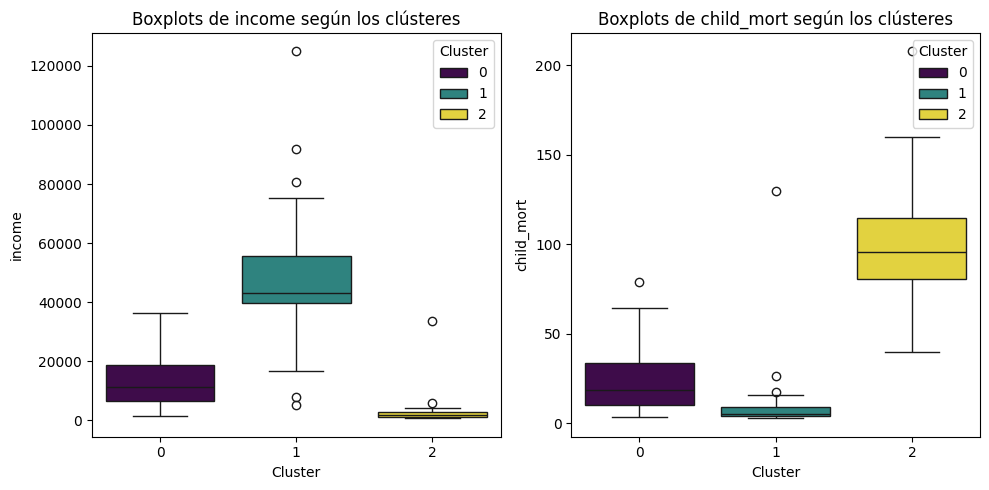

In [ ]:
_, ax = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(x=df_ind_esc["Cluster"], y=df_ong["income"], hue=df_ind_esc["Cluster"], ax=ax[0], palette="viridis")
ax[0].set_title("Boxplots de income según los clústeres")
sns.boxplot(x=df_ind_esc["Cluster"], y=df_ong["child_mort"], hue=df_ind_esc["Cluster"], ax=ax[1], palette="viridis")
ax[1].set_title("Boxplots de child_mort según los clústeres")
plt.tight_layout()
plt.show()

In [ ]:
df_map = df_ong.copy()
df_map["Cluster"] = df_ind_esc["Cluster"]

# Voy a crear una nueva columna con un nombre más descriptivo. Para establecer los niveles, me he fijado en los rangos de valores de income y child_mort
df_map["Nivel_Ayuda"] = df_map["Cluster"].map({
    0: "Necesita ayuda moderada",
    1: "No necesita ayuda",
    2: "Necesita mucha ayuda"
})

fig = px.choropleth(
    df_map,
    locations="country",
    locationmode="country names",
    color="Nivel_Ayuda",
    hover_name="country",
    color_discrete_map={
        "Necesita mucha ayuda": "red",
        "Necesita ayuda moderada": "orange",
        "No necesita ayuda": "green"
    },
    title="Nivel de ayuda necesaria por país",
    height=600
)

fig.show()